In [1]:
building_id = 2
price = 106
iteration = 13
# we are ready to run!
ga_file="something.xlsx"
ga_proc="something_else.xlsx"
ga_fina="something_something.xlsx"
runs_num=1
run_i=2
base_path=""

In [2]:
# Parameters
ga_file = "panel_106_dual_100_5.xlsx"
ga_proc = "panel_106_dual_archive_100_5.xlsx"
ga_fina = "panel_106_dual_processed_100_5.xlsx"
runs_num = 100
run_i = 5


In [3]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [4]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}/".format(runs_num,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [7]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [8]:
pvbuilding.North_Axis

0.0

In [9]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [10]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


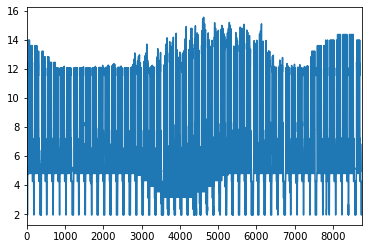

In [11]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [12]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [13]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m²
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [14]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.022850513458252 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.93937087059021 sec


ERROR:root:Finished Generation of Irradiance


0.0


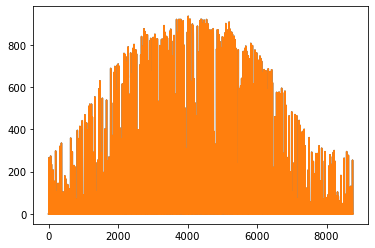

In [15]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8159339427948 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8320696353912354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8338677883148193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 183 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


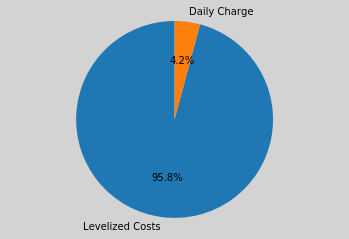

Total roof area of the  building: 599 m²
Total roof area used 473 m²
Percentage: 79.0%


In [16]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [17]:
my_model.energyIm

61845.7

In [18]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [19]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [20]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [21]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [22]:
my_model.solveResults['solution']['any_above_35']

0

In [23]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [24]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [25]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [26]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


Found the solver set
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245, 260, 250, 6, 56, 46, 0.44999999999999996, 0.8999999999999999, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 6.0
                                           and a gcr of 0.450


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1218762397766113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 56.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.821772813796997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8376708030700684 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 178 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [136.918, 0.0, 250.325]


ERROR:ga_logger:Cost: 3979.23


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,979 per year


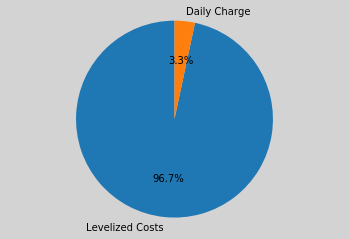

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[245, 260, 250, 6, 56, 46, 0.44999999999999996, 0.8999999999999999, 0.8499999999999999, 3979.23, 387.243, 136.918, 0.0, 250.325, {'Levelized Costs': 3846.1870000000004, 'Energy Charge': 0.0009999999998626663, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60114769996, 61845.7, 598.762]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (230, 240, 165, 16, 36, 21, 0.6499999999999999, 0.3, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 230
                                           a tilt of 16.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.853651285171509 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 240
                                           a tilt of 36.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8366799354553223 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 165
                                           a tilt of 21.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8259739875793457 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 182 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 275s


ERROR:ga_logger:panel relevance: [188.456, 0.0, 123.532]


ERROR:ga_logger:Cost: 3231.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


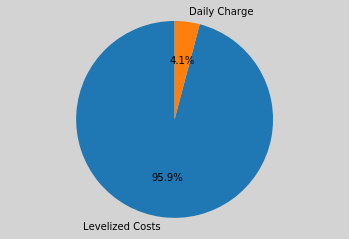

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[230, 240, 165, 16, 36, 21, 0.6499999999999999, 0.3, 0.39999999999999997, 3231.78, 311.988, 188.456, 0.0, 123.532, {'Levelized Costs': 3098.734, 'Energy Charge': 0.00400000000018963, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601162320534, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (140, 185, 185, 31, 21, 36, 0.7, 0.49999999999999994, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 31.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9041826725006104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 21.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3873817920684814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 36.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8237245082855225 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 176 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 195s


ERROR:ga_logger:panel relevance: [0.0, 298.339, 0.0]


ERROR:ga_logger:Cost: 3096.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,096 per year


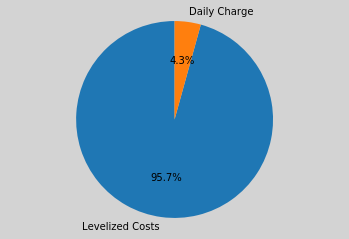

Total roof area of the  building: 599 m²
Total roof area used 597 m²
Percentage: 99.7%
[[140, 185, 185, 31, 21, 36, 0.7, 0.49999999999999994, 0.5999999999999999, 3096.22, 298.339, 0.0, 298.339, 0.0, {'Levelized Costs': 2963.1719999999996, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60037357128, 61845.7, 596.679]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (255, 245, 100, 11, 41, 46, 0.5999999999999999, 0.5499999999999999, 0.49999999999999994)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 255
                                           a tilt of 11.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9973835945129395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 41.0
                                           and a gcr of 0.550

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.876206636428833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8681142330169678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 173 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [334.567, 0.0, 0.0]


ERROR:ga_logger:Cost: 3456.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,456 per year


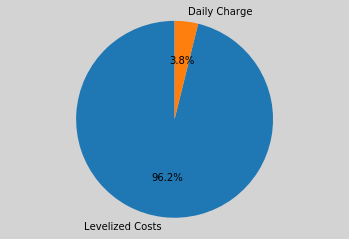

Total roof area of the  building: 599 m²
Total roof area used 558 m²
Percentage: 93.1%
[[255, 245, 100, 11, 41, 46, 0.5999999999999999, 0.5499999999999999, 0.49999999999999994, 3456.04, 334.567, 334.567, 0.0, 0.0, {'Levelized Costs': 3322.9779999999996, 'Energy Charge': 0.020000000000209184, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59934202991, 61845.7, 557.611]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 170, 140, 21, 16, 21, 0.8499999999999999, 0.44999999999999996, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 21.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8633811473846436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 170
                                           a tilt of 16.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8489480018615723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 21.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.979339599609375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [77.7026, 228.306, 0.0]


ERROR:ga_logger:Cost: 3172.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,172 per year


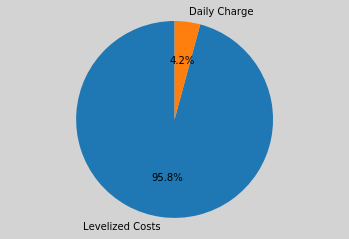

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 170, 140, 21, 16, 21, 0.8499999999999999, 0.44999999999999996, 0.8499999999999999, 3172.4, 306.0086, 77.7026, 228.306, 0.0, {'Levelized Costs': 3039.35, 'Energy Charge': 0.008000000000322416, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60099538713, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 230, 235, 11, 36, 11, 0.49999999999999994, 0.6499999999999999, 0.39999999999999997)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.500


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.818187713623047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 36.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8322832584381104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.884577512741089 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 333 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [243.492, 72.6552, 0.0]


ERROR:ga_logger:Cost: 3273.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,273 per year


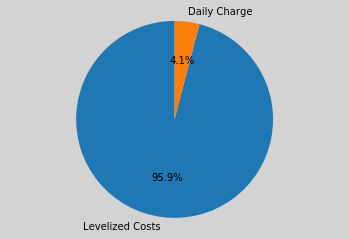

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[175, 230, 235, 11, 36, 11, 0.49999999999999994, 0.6499999999999999, 0.39999999999999997, 3273.1, 316.1472, 243.492, 72.6552, 0.0, {'Levelized Costs': 3140.029, 'Energy Charge': 0.02900000000011005, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6025333589, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 110, 110, 11, 36, 46, 0.8499999999999999, 0.49999999999999994, 0.7999999999999998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 11.0
                                           and a gcr of 0.850


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.224684953689575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 110
                                           a tilt of 36.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9280693531036377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 110
                                           a tilt of 46.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8696794509887695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 166 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [335.324, 0.0, 0.0]


ERROR:ga_logger:Cost: 3463.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,464 per year


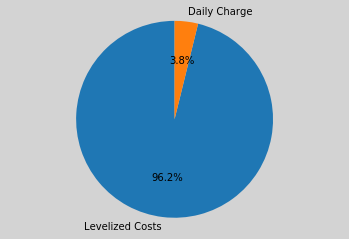

Total roof area of the  building: 599 m²
Total roof area used 394 m²
Percentage: 65.9%
[[240, 110, 110, 11, 36, 46, 0.8499999999999999, 0.49999999999999994, 0.7999999999999998, 3463.56, 335.324, 335.324, 0.0, 0.0, {'Levelized Costs': 3330.4999999999995, 'Energy Charge': 0.018000000000256478, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59914371063, 61845.7, 394.499]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 200, 150, 6, 46, 31, 0.25, 0.8499999999999999, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 6.0
                                           and a gcr of 0.250


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.01082706451416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 46.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.920170307159424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 31.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9235944747924805 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 163 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 158s


ERROR:ga_logger:panel relevance: [0.0, 88.9379, 222.358]


ERROR:ga_logger:Cost: 3224.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,225 per year


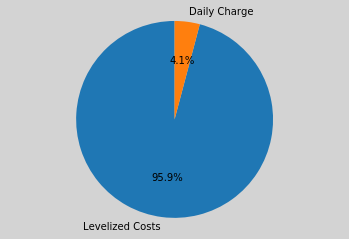

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 200, 150, 6, 46, 31, 0.25, 0.8499999999999999, 0.44999999999999996, 3224.91, 311.2959, 0.0, 88.9379, 222.358, {'Levelized Costs': 3091.8559999999998, 'Energy Charge': 0.012000000000114142, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601117862854, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 105, 225, 6, 31, 31, 0.5999999999999999, 0.7999999999999998, 0.8999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 6.0
                                           and a gcr of 0.600


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9802653789520264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 31.0
                                           and a gcr of 0.800


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8918230533599854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 225
                                           a tilt of 31.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.981921911239624 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 213 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [320.496, 0.0, 0.0]


ERROR:ga_logger:Cost: 3316.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,316 per year


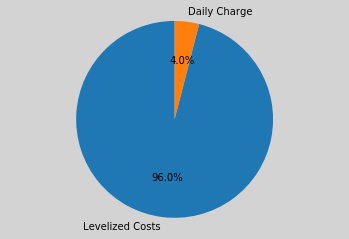

Total roof area of the  building: 599 m²
Total roof area used 534 m²
Percentage: 89.2%
[[185, 105, 225, 6, 31, 31, 0.5999999999999999, 0.7999999999999998, 0.8999999999999999, 3316.29, 320.496, 320.496, 0.0, 0.0, {'Levelized Costs': 3183.229, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60225592127, 61845.7, 534.16]]
The maximum power used is 16 kW


The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (185, 185, 250, 26, 31, 16, 0.7, 0.39999999999999997, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 26.0
                                           and a gcr of 0.700


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9492945671081543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 31.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8736469745635986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 16.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8579771518707275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 180 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [134.739, 162.511, 0.0]


ERROR:ga_logger:Cost: 3085.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,085 per year


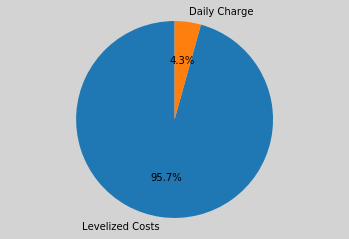

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[185, 185, 250, 26, 31, 16, 0.7, 0.39999999999999997, 0.5999999999999999, 3085.4, 297.25, 134.739, 162.511, 0.0, {'Levelized Costs': 2952.342, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6017808416, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 125, 115, 26, 36, 21, 0.3, 0.44999999999999996, 0.35)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 26.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.047750234603882 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0018301010131836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 21.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.025329828262329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 211 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 269.443, 0.0]


ERROR:ga_logger:Cost: 4115.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0211 /kWh
Total Cost of the system: $ 4,116 per year


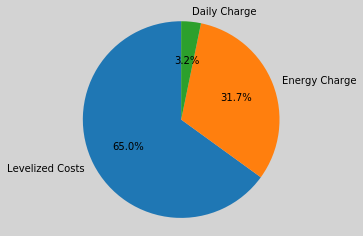

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[200, 125, 115, 26, 36, 21, 0.3, 0.44999999999999996, 0.35, 4115.99, 269.443, 0.0, 269.443, 0.0, {'Levelized Costs': 2676.1609999999996, 'Energy Charge': 1306.7870000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 51416.43717815986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100, 115, 260, 46, 56, 21, 0.6499999999999999, 0.7, 0.25)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 100
                                           a tilt of 46.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0294530391693115 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 56.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.806959867477417 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 21.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393345355987549 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 287 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [46.5564, 368.995, 0.0]


ERROR:ga_logger:Cost: 4260.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,260 per year


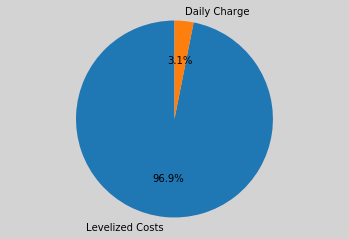

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[100, 115, 260, 46, 56, 21, 0.6499999999999999, 0.7, 0.25, 4260.4, 415.5514, 46.5564, 368.995, 0.0, {'Levelized Costs': 4127.338999999999, 'Energy Charge': 0.019000000000005457, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60140890003, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (160, 105, 215, 56, 41, 51, 0.7999999999999998, 0.25, 0.8499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 160
                                           a tilt of 56.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.048912286758423 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 105
                                           a tilt of 41.0
                                           and a gcr of 0.250


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2732787132263184 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 215
                                           a tilt of 51.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4976866245269775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 315 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 94s


ERROR:ga_logger:panel relevance: [294.981, 57.5088, 0.0]


ERROR:ga_logger:Cost: 3634.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,634 per year


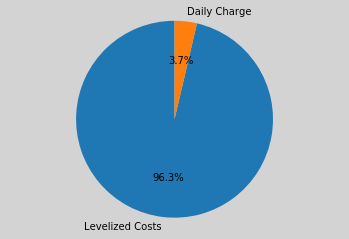

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[160, 105, 215, 56, 41, 51, 0.7999999999999998, 0.25, 0.8499999999999999, 3634.06, 352.4898, 294.981, 57.5088, 0.0, {'Levelized Costs': 3501.0049999999997, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60151208983, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240, 130, 180, 6, 21, 56, 0.7999999999999998, 0.44999999999999996, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 6.0
                                           and a gcr of 0.800


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.130281686782837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 21.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4310247898101807 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 56.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5362014770507812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 266 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [113.497, 205.601, 0.0]


ERROR:ga_logger:Cost: 3302.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,302 per year


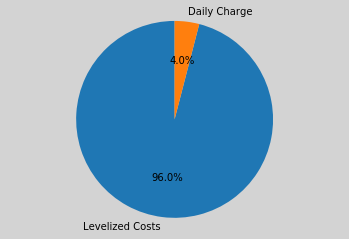

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[240, 130, 180, 6, 21, 56, 0.7999999999999998, 0.44999999999999996, 0.44999999999999996, 3302.4, 319.098, 113.497, 205.601, 0.0, {'Levelized Costs': 3169.3430000000003, 'Energy Charge': 0.014999999999758984, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602589103124, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145, 95, 210, 41, 46, 16, 0.39999999999999997, 0.6499999999999999, 0.5499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 41.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0602285861968994 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 95
                                           a tilt of 46.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1532583236694336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 210
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.393420934677124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 322 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 97s


ERROR:ga_logger:panel relevance: [52.745, 0.0, 256.795]


ERROR:ga_logger:Cost: 3207.47


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,207 per year


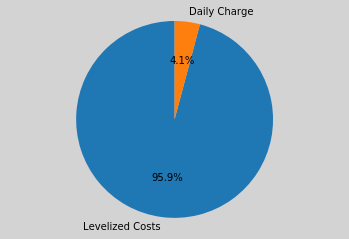

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[145, 95, 210, 41, 46, 16, 0.39999999999999997, 0.6499999999999999, 0.5499999999999999, 3207.47, 309.54, 52.745, 0.0, 256.795, {'Levelized Costs': 3074.4009999999994, 'Energy Charge': 0.02700000000027103, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59838933822, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135, 210, 235, 46, 26, 26, 0.5499999999999999, 0.8499999999999999, 0.3)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 46.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.027319431304932 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 26.0
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.14067530632019 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 26.0
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.584287643432617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 306 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 105s


ERROR:ga_logger:panel relevance: [0.0, 223.806, 100.638]


ERROR:ga_logger:Cost: 3355.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


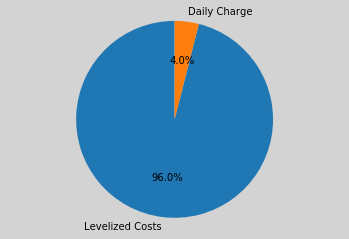

Total roof area of the  building: 599 m²
Total roof area used 599 m²
Percentage: 100.0%
[[135, 210, 235, 46, 26, 26, 0.5499999999999999, 0.8499999999999999, 0.3, 3355.5, 324.444, 0.0, 223.806, 100.638, {'Levelized Costs': 3222.44, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59961594722, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 235, 180, 41, 11, 31, 0.3, 0.49999999999999994, 0.5999999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 41.0
                                           and a gcr of 0.300


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3440139293670654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 11.0
                                           and a gcr of 0.500


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.900015354156494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 180
                                           a tilt of 31.0
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8455896377563477 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 298 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


[[165, 235, 180, 41, 11, 31, 0.3, 0.49999999999999994, 0.5999999999999999, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200, 165, 115, 6, 16, 6, 0.39999999999999997, 0.5499999999999999, 0.6499999999999999)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.0
                                           and a gcr of 0.400


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.964484691619873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 16.0
                                           and a gcr of 0.550


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8380115032196045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 115
                                           a tilt of 6.0
                                           and a gcr of 0.650


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.133829355239868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 309 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [0.0, 304.926, 0.0]


ERROR:ga_logger:Cost: 3161.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


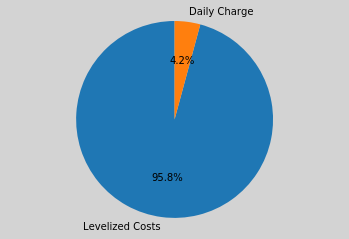

Total roof area of the  building: 599 m²
Total roof area used 554 m²
Percentage: 92.6%
[[200, 165, 115, 6, 16, 6, 0.39999999999999997, 0.5499999999999999, 0.6499999999999999, 3161.64, 304.926, 0.0, 304.926, 0.0, {'Levelized Costs': 3028.5829999999996, 'Energy Charge': 0.015000000000384262, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602390179985, 61845.7, 554.411]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175, 230, 95, 11, 26, 36, 0.5499999999999999, 0.39999999999999997, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 11.0
                                           and a gcr of 0.550


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1455039978027344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 26.0
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.479273796081543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 36.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6310200691223145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 342 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [310.717, 0.0, 0.0]


ERROR:ga_logger:Cost: 3219.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,219 per year


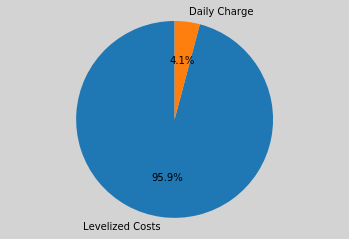

Total roof area of the  building: 599 m²
Total roof area used 565 m²
Percentage: 94.4%
[[175, 230, 95, 11, 26, 36, 0.5499999999999999, 0.39999999999999997, 0.44999999999999996, 3219.16, 310.717, 310.717, 0.0, 0.0, {'Levelized Costs': 3086.0969999999998, 'Energy Charge': 0.021000000000299224, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60053663348, 61845.7, 564.941]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165, 135, 100, 26, 16, 26, 0.6499999999999999, 0.35, 0.44999999999999996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2680814266204834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 135
                                           a tilt of 16.0
                                           and a gcr of 0.350


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.904195785522461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 100
                                           a tilt of 26.0
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0226473808288574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 402 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 177s


ERROR:ga_logger:panel relevance: [303.772, 0.0, 0.0]


ERROR:ga_logger:Cost: 3150.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,150 per year


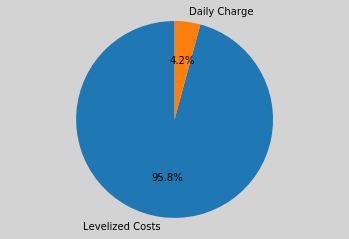

Total roof area of the  building: 599 m²
Total roof area used 467 m²
Percentage: 78.1%
[[165, 135, 100, 26, 16, 26, 0.6499999999999999, 0.35, 0.44999999999999996, 3150.18, 303.772, 303.772, 0.0, 0.0, {'Levelized Costs': 3017.1169999999997, 'Energy Charge': 0.021000000000185537, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599942500136, 61845.7, 467.341]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205, 120, 150, 21, 16, 51, 0.5499999999999999, 0.44999999999999996, 0.5999999999999999)


In [27]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)
if (runs_num ==1):
    init_pop=1
else:
    init_pop=50
    
pvoptimizer.runGA(runs_num,init_pop,"BC","DUAL")
pvoptimizer.processGA(ga_fina)
# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Time in minutes for the {} runs frequency {}:".format(runs_num,run_i))
lrun.error(mintime)
